In [1]:
import math

import h5py
import numpy as np
import matplotlib.pyplot as plt

## Inputs

In [2]:
maxtime = 11000
variable = "V_A"

## Setting up variables for plotting

In [3]:
variables = ["V_A", "V_B", "Cell volume", "Na_C", "K_C", "Cl_C", "NCO_C", "Cellular pH", "CO_C"]
units = ["(mV)", "(mV)", "(um3)", "(mM)", "(mM)", "(mM)", "(mM)", "", "mM"]
scalevar = {
    "Cellular pH": lambda x: -np.log10(x * 1e-3),
}
varidx = variables.index(variable)

## Load C++ results

In [4]:
results = h5py.File('_duct_results.h5', 'r')
print(results)

x = np.asarray(results['_duct/x'])
print("x shape", x.shape)

# cell position
cellpos = np.asarray(results['_duct/CellPos'])
print("CellPos shape", cellpos.shape)

# sorting cell positions
#sortedidx = np.argsort(cellpos)
#cellpos = np.sort(cellpos)
#sortedidx = np.flip(sortedidx)
#cellpos = np.flip(cellpos)
#print(cellpos)

# lumen segment positions
intpos = np.asarray(results['_duct/IntPos'])
print("IntPos shape", intpos.shape)

# attributes for x array
for key in results['_duct'].attrs.keys():
    print(f"{key}: {results['_duct'].attrs[key]}")
v_c = results['_duct'].attrs['number of cellular variables']
v_l = results['_duct'].attrs['number of lumenal variables']
n_c = results['_duct'].attrs['number of cells']
n_l = results['_duct'].attrs['number of lumen discs']

# time values
dt = results.attrs["output time interval"]
print("output time interval: %f s" % dt)
timevals = np.arange(0.0, x.shape[0]*dt-0.5*dt, dt)
assert timevals.shape[0] == x.shape[0]

<HDF5 file "_duct_results.h5" (mode r)>
x shape (1101, 588)
CellPos shape (36,)
IntPos shape (44,)
number of cells: 36
number of cellular variables: 9
number of lumen discs: 44
number of lumenal variables: 6
output time interval: 10.000000 s


## Load Matlab results

In [5]:
results_mat = h5py.File('matlab_results.h5', 'r')
print(results_mat)

x_mat = np.asarray(results_mat['/x'])
print("x_mat shape", x_mat.shape)

# time values
timevals_mat = np.asarray(results_mat['/t'])[:,0]

<HDF5 file "matlab_results.h5" (mode r)>
x_mat shape (147, 588)


## Prepare to plot C++ results

In [6]:
indx = timevals < maxtime
tbeg = timevals[indx]
xbeg = x[indx, :]
print("xbeg shape", xbeg.shape)
xcbeg = xbeg[:, :n_c*v_c].reshape(len(tbeg), n_c, v_c)
print('xcbeg shape', xcbeg.shape)

xbeg shape (1100, 588)
xcbeg shape (1100, 36, 9)


## Prepare to plot Matlab results

In [7]:
indx_mat = timevals_mat < maxtime
tbeg_mat = timevals_mat[indx_mat]
xbeg_mat = x_mat[indx_mat, :]
print("xbeg_mat shape", xbeg_mat.shape)
xcbeg_mat = xbeg_mat[:, :n_c*v_c].reshape(len(tbeg_mat), n_c, v_c)
print('xcbeg_mat shape', xcbeg_mat.shape)

xbeg_mat shape (146, 588)
xcbeg_mat shape (146, 36, 9)


## Plotting

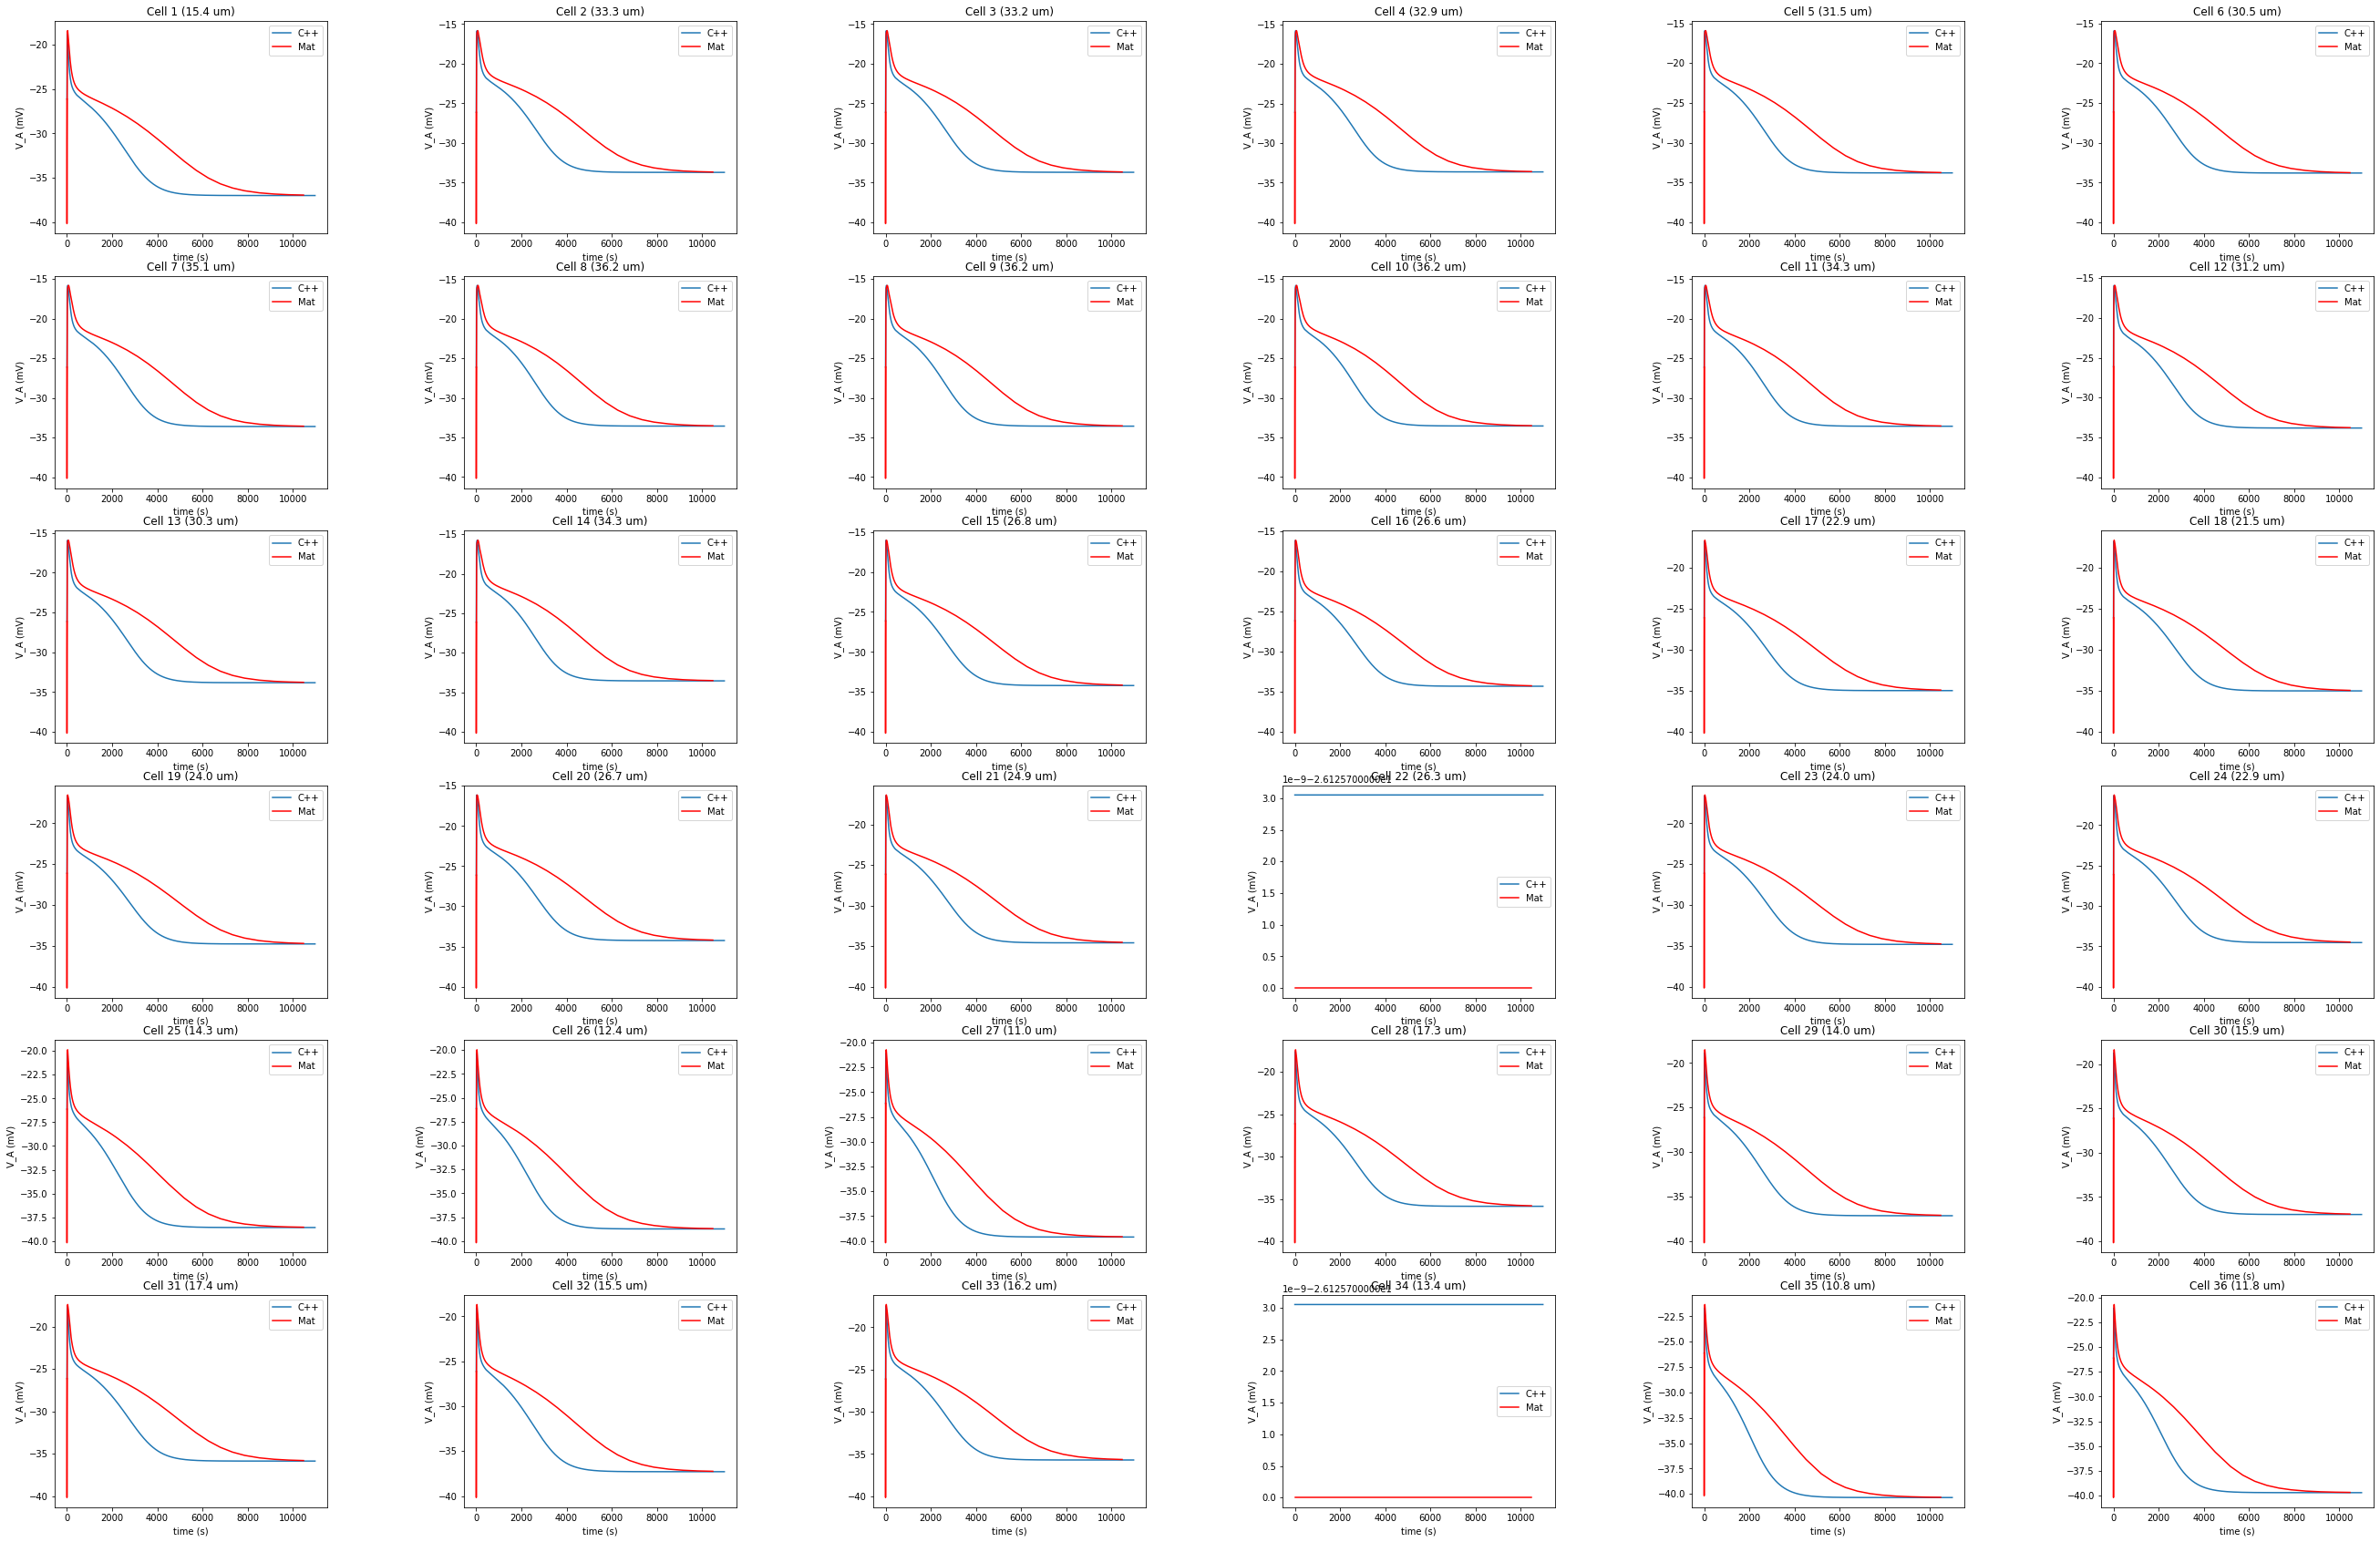

In [8]:
# cell plot, n_c is number of cells
ncol = math.ceil(math.sqrt(n_c))
nrow = math.ceil(n_c / ncol)

# create the plot
fig, plots = plt.subplots(nrow, ncol, squeeze=False)
plt.subplots_adjust(wspace = 0.5)
fig.set_size_inches(ncol * 7.6, nrow * 5.0)
#fig.suptitle("t = %.3f s (%s)" % (timevals[-1], os.getcwd()))

# loop over cells
for cell0 in range(n_c):
    # subplot coord
    row = cell0 // ncol
    col = cell0 % ncol
    
    # C++ yvals, scale if necessary
    yvals = xcbeg[:, cell0, varidx]
    if variable in scalevar:
        yvals = scalevar[variable](yvals)
    # plot C++
    plots[row, col].plot(tbeg, yvals, label="C++")
    
    # Matlab yvals, scale if necessary
    yvals = xcbeg_mat[:, cell0, varidx]
    if variable in scalevar:
        yvals = scalevar[variable](yvals)
    # plot Matlab
    plots[row, col].plot(tbeg_mat, yvals, label="Mat", color='red')
    
    plots[row, col].set_title(f"Cell {cell0+1} ({cellpos[cell0]:.1f} um)")
    plots[row, col].set_xlabel("time (s)")
    plots[row, col].legend(loc='best')
    plots[row, col].set_ylabel(f"{variable} {units[varidx]}")

In [9]:
fig.savefig('plot_time_compare.pdf')